In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as awk
from scipy.interpolate import interp1d
import os

In [3]:
def create_get_min_efficiency(filename="kaon_decay_efficiency_data.txt", skip_rows=0, m_n_min=20, m_n_max=400, m_n_step=25):
    m_n, min_decay = np.loadtxt(filename, skiprows=skip_rows, usecols=(0, 1), unpack=True)
    extended_m_n = np.arange(m_n_min, m_n_max + m_n_step, m_n_step)
    
    # Perform interpolation only where necessary
    mask = (extended_m_n < m_n[0]) | (extended_m_n > m_n[-1])
    extended_min = np.interp(extended_m_n, m_n, min_decay)
    
    interp_func = interp1d(m_n, min_decay, kind='linear', bounds_error=False, fill_value=(min_decay[0], min_decay[-1]))
    extended_min[~mask] = interp_func(extended_m_n[~mask])
    
    # Create final interpolation function
    min_efficiency_interp = interp1d(extended_m_n, extended_min, kind='linear', bounds_error=False, fill_value='extrapolate')
    
    return min_efficiency_interp

get_min_efficiency = create_get_min_efficiency()

In [4]:
def weighted_median(values, weights):
    """Compute the weighted median of a 1D array."""
    # Sort values and weights based on values
    sorted_indices = np.argsort(values)
    sorted_values = np.array(values)[sorted_indices]
    sorted_weights = np.array(weights)[sorted_indices]
    
    # Compute cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = np.sum(sorted_weights)
    
    # Find the index where cumulative weight exceeds half of total weight
    median_idx = np.searchsorted(cumulative_weights, total_weight / 2)
    
    return sorted_values[median_idx]

Minimal HNL cosθ<90% Efficiency vs mass

In [13]:
n_m, n_U = 20, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()[0:20]
U_sample = U_sample.flatten()[0:20]

TPC_boxes = np.array([
    [0, 0, -0.375, 2.5, 2.5, 1.0],
    [0, 0, 0.99, 2.5, 2.5, 1.0],
    [0, 0, 2.355, 2.5, 2.5, 1.0]
    # ,[0, 0.74, -0.795, 1.795, 0.795, 2] # New TPC in ND280 Upgrade
    # ,[0, -0.74, -0.795, 1.795, 0.795, 2] # New TPC in ND280 Upgrade
]) # TPC dimensions extracted from densities file

def is_points_in_boxes(points, boxes):
    points = np.asarray(points)
    boxes = np.asarray(boxes)
    centers, dimensions = boxes[:, :3], boxes[:, 3:]
    
    # Broadcasting to compare all points with all boxes
    in_bounds = np.all(
        (points[:, np.newaxis, :] >= centers - dimensions/2) & 
        (points[:, np.newaxis, :] <= centers + dimensions/2),
        axis=2
    )
    # print(f'Number of points in boxes: {np.sum(np.any(in_bounds, axis=1))/100000:3.3e}')
    # Check if each point is in any box
    return np.any(in_bounds, axis=1)

def ang_median(m, U, tag='scatter', plot=True):
    file_paths = [
        f'./minHNL_OGTPC/OGTPC1_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet',
        f'./minHNL_OGTPC/OGTPC2_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet',
        f'./minHNL_OGTPC/OGTPC3_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet'
    ]

    # Check if all three files file exists
    if not all(os.path.isfile(fp) for fp in file_paths):
        print(f"Skip M:{m:2.2e}, U:{U:2.2e}\n")
        return

    weights_list, mtms_list = [], []
    
    for loc in file_paths:
        if os.path.isfile(loc):  # Ensure the file exists before reading
            data = awk.from_parquet(loc)
            weights = data.event_weight * is_points_in_boxes(data.vertex[:,0], TPC_boxes)
            mask = ~np.isnan(weights)
            weights_list.append(weights[mask])

            if tag == 'scatter':
                mtms_list.append(data.secondary_momenta[mask, 1][:, 1:3])
            else:
                mtms_list.append(data.secondary_momenta[mask, 0][:, 1:3])

    # Concatenate weights and momenta
    weights = np.concatenate(weights_list)
    mtms = np.concatenate(mtms_list, axis=0)

    # Extract the vectors for computation
    vec1, vec2 = mtms[:, 0, :], mtms[:, 1, :]

    # Compute the dot product and norms in a vectorized manner
    dot_products = np.einsum('ij,ij->i', vec1, vec2)  
    norms1 = np.linalg.norm(vec1, axis=1)
    norms2 = np.linalg.norm(vec2, axis=1)

    # Compute cosine of the angle
    angs = dot_products / (norms1 * norms2)

    # Compute efficiency
    med = weighted_median(angs, weights)
    
    # Plot histogram if needed
    if plot:
        plt.hist(angs, bins=100, range=(0.9, 1), edgecolor='black', weights=weights)
        plt.xlabel('Cosine of angle')
        plt.ylabel('Frequency')
        plt.title('Angle Distribution')
        plt.show()
    
    return med, angs

m_effs = []

for m, U in zip(m_sample, U_sample):

    try:
        med = ang_median(m,U,tag='decay',plot=False)[0]
    except:
        continue
    m_effs.append([m,med,get_min_efficiency(m*1000)])
    
    print(f'Finished M {m:2.2e}, U {U:2.2e}')


Finished M 2.00e-02, U 1.00e-07
Finished M 2.34e-02, U 1.00e-07
Finished M 2.74e-02, U 1.00e-07
Finished M 3.21e-02, U 1.00e-07
Finished M 3.76e-02, U 1.00e-07
Finished M 4.40e-02, U 1.00e-07
Finished M 5.15e-02, U 1.00e-07
Finished M 6.03e-02, U 1.00e-07
Finished M 7.06e-02, U 1.00e-07
Finished M 8.27e-02, U 1.00e-07
Finished M 9.68e-02, U 1.00e-07
Finished M 1.13e-01, U 1.00e-07
Finished M 1.33e-01, U 1.00e-07
Finished M 1.55e-01, U 1.00e-07
Finished M 1.82e-01, U 1.00e-07
Finished M 2.13e-01, U 1.00e-07
Finished M 2.49e-01, U 1.00e-07
Finished M 2.92e-01, U 1.00e-07
Finished M 3.42e-01, U 1.00e-07
Finished M 4.00e-01, U 1.00e-07


In [14]:
m_effs

[[0.02, 0.9999726062727574, array(0.0708227)],
 [0.02341559827445559, 0.9999657516605932, array(0.07298076)],
 [0.02741451212753437, 0.9999547970857044, array(0.07550737)],
 [0.03209636014342678, 0.9999478146425872, array(0.07846547)],
 [0.037577773759536456, 0.9999243033338894, array(0.08192876)],
 [0.04399530272008421, 0.9999065770806734, array(0.08598351)],
 [0.051508816722827776, 0.999918769463604, array(0.08624845)],
 [0.06030548799871476, 0.9999166043526128, array(0.08574858)],
 [0.07060445403614536, 0.999877745558602, array(0.08529797)],
 [0.0826622766048822, 0.9998649460429287, array(0.08729812)],
 [0.09677933307159249, 0.9998397395701139, array(0.08963237)],
 [0.11330729922370722, 0.9998228522653172, array(0.09230446)],
 [0.13265791000929306, 0.9997965602408826, array(0.0939669)],
 [0.15531321643532436, 0.99975342609562, array(0.09713417)],
 [0.18183759413815645, 0.9996868057936544, array(0.09995913)],
 [0.21289180277662856, 0.9996531289290819, array(0.10025347)],
 [0.24924944

Text(0, 0.5, 'Total Efficiency')

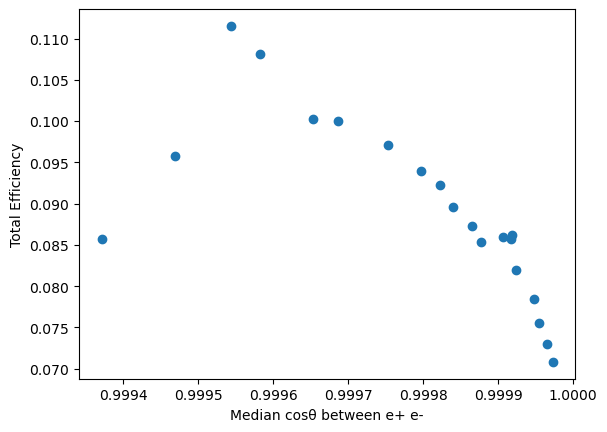

In [17]:
m_effs = np.asarray(m_effs)
plt.scatter(m_effs[:,1],m_effs[:,2])
plt.xlabel('Median cosθ between e+ e-')
plt.ylabel('Total Efficiency')

In [18]:
n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])[0:10]
mu_sample = np.reshape(mu_sample,[n_m*n_mu])[0:10]

def ang_med(m, U, tag='scatter', plot=True):
    file_paths = [
        f'./dipHNL_OGTPC/OGTPC1_Dipole_M{m:2.2e}_mu{U:2.2e}_example.parquet',
        f'./dipHNL_OGTPC/OGTPC2_Dipole_M{m:2.2e}_mu{U:2.2e}_example.parquet',
        f'./dipHNL_OGTPC/OGTPC3_Dipole_M{m:2.2e}_mu{U:2.2e}_example.parquet'
    ]

    # Check if all three files file exists
    if not all(os.path.isfile(fp) for fp in file_paths):
        print(f"Skip M:{m:2.2e}, U:{U:2.2e}\n")
        return

    weights_list, mtms_list = [], []
    
    for loc in file_paths:
        if os.path.isfile(loc):  # Ensure the file exists before reading
            data = awk.from_parquet(loc)
            weights = data.event_weight
            mask = ~np.isnan(weights)
            weights_list.append(weights[mask])

            if tag == 'scatter':
                mtms_list.append(data.secondary_momenta[mask, 1][:, 1:3])
            else:
                mtms_list.append(data.secondary_momenta[mask, 0][:, 1:3])

    # Concatenate weights and momenta
    weights = np.concatenate(weights_list)
    mtms = np.concatenate(mtms_list, axis=0)

    # Extract the vectors for computation
    vec1, vec2 = mtms[:, 0, :], mtms[:, 1, :]

    # Compute the dot product and norms in a vectorized manner
    dot_products = np.einsum('ij,ij->i', vec1, vec2)  
    norms1 = np.linalg.norm(vec1, axis=1)
    norms2 = np.linalg.norm(vec2, axis=1)

    # Compute cosine of the angle
    angs = dot_products / (norms1 * norms2)

    # Compute efficiency
    med = weighted_median(angs, weights)
    
    # Plot histogram if needed
    if plot:
        plt.hist(angs, bins=100, range=(0.9, 1), edgecolor='black', weights=weights)
        plt.xlabel('Cosine of angle')
        plt.ylabel('Frequency')
        plt.title('Angle Distribution')
        plt.show()
    
    return med, angs

m_effs = []

for m, mu in zip(m_sample, mu_sample):
    try:
        med = ang_med(m,mu,tag='scatter',plot=False)[0]
    except:
        continue
    m_effs.append([m,med,get_min_efficiency(m*1000)])

Skip M:2.00e+00, U:1.00e-07



In [21]:
m_effs

array([[0.01      , 0.99986481, 0.06450446],
       [0.01801648, 0.99973037, 0.06956947],
       [0.03245936, 0.99938075, 0.07869483],
       [0.05848035, 0.99903061, 0.0858523 ],
       [0.10536103, 0.99846381, 0.09101978],
       [0.18982351, 0.99796111, 0.09936579],
       [0.34199519, 0.99839519, 0.09564793],
       [0.61615503, 0.99948864, 0.08571429],
       [1.11009462, 0.99968301, 0.08571429]])

Text(0, 0.5, 'Opening angle cosθ')

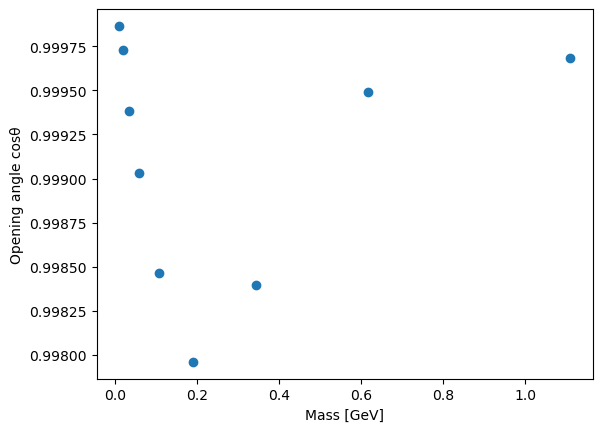

In [23]:
m_effs = np.asarray(m_effs)
plt.scatter(m_effs[:,0],m_effs[:,1])
plt.xlabel('Mass [GeV]')
plt.ylabel('Opening angle cosθ')

Text(0, 0.5, 'Efficiency')

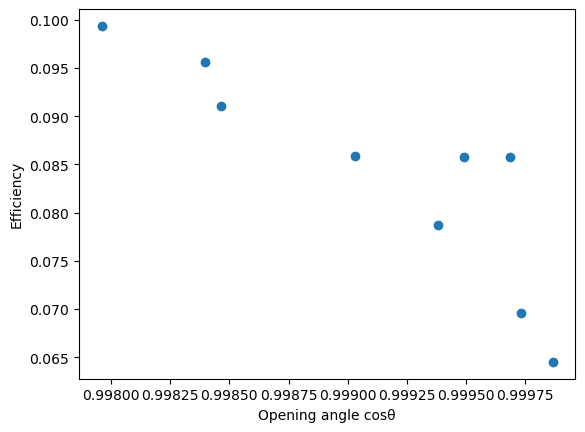

In [24]:
m_effs = np.asarray(m_effs)
plt.scatter(m_effs[:,1],m_effs[:,2])
plt.xlabel('Opening angle cosθ')
plt.ylabel('Efficiency')

In [2]:
n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])[0:10]
mu_sample = np.reshape(mu_sample,[n_m*n_mu])[0:10]

for m,mu in zip(m_sample,mu_sample):
    

if not os.path.isfile(loc):
    print("Skip "+loc)
    return

data = awk.from_parquet(loc)

weights = data.event_weight

mask = ~np.isnan(weights)

weights = weights[mask]

if tag == 'scatter':
    # Extract the relevant sub-arrays
    mtms = data.secondary_momenta[mask, 1][:, 1:3]
else:
    mtms = data.secondary_momenta[mask, 0][:, 1:3]
    

# Extract the vectors for computation
vec1 = mtms[:, 0, 1:4]
vec2 = mtms[:, 1, 1:4]

# Compute the dot product and norms in a vectorized manner
dot_products = np.einsum('ij,ij->i', vec1, vec2)  # Efficient dot product for rows
norms1 = np.linalg.norm(vec1, axis=1)
norms2 = np.linalg.norm(vec2, axis=1)

# Compute cosine of the angle
angs = dot_products / (norms1 * norms2)

eff = np.sum(weights*(angs>np.cos(0.9/180*np.pi)))/np.sum(weights)

if plot:
    plt.hist(angs, bins=100, range=(0.9,1),edgecolor='black',weights = weights)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

return eff, angs


In [2]:
n_m, n_U = 20, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

In [28]:
def angles(loc, tag='scatter', plot=True):
    
    if not os.path.isfile(loc):
        print("Skip "+loc)
        return
    
    data = awk.from_parquet(loc)
    
    weights = data.event_weight

    mask = ~np.isnan(weights)

    weights = weights[mask]

    if tag == 'scatter':
        # Extract the relevant sub-arrays
        mtms = data.secondary_momenta[mask, 1][:, 1:3]
    else:
        mtms = data.secondary_momenta[mask, 0][:, 1:3]
        

    # Extract the vectors for computation
    vec1 = mtms[:, 0, 1:4]
    vec2 = mtms[:, 1, 1:4]

    # Compute the dot product and norms in a vectorized manner
    dot_products = np.einsum('ij,ij->i', vec1, vec2)  # Efficient dot product for rows
    norms1 = np.linalg.norm(vec1, axis=1)
    norms2 = np.linalg.norm(vec2, axis=1)

    # Compute cosine of the angle
    angs = dot_products / (norms1 * norms2)

    eff = np.sum(weights*(angs>np.cos(0.9/180*np.pi)))/np.sum(weights)
    
    if plot:
        plt.hist(angs, bins=100, range=(0.9,1),edgecolor='black',weights = weights)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title('Histogram')
        plt.show()
    
    return eff, angs
    

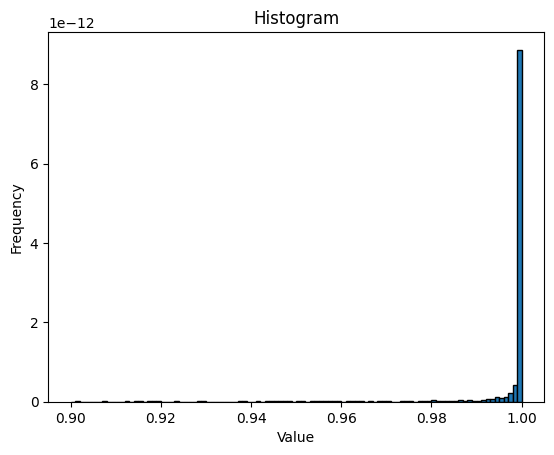

In [22]:
loc = './test/OGTPC3_Dipole_M2.00e-02_Umu1.00e-07_example.parquet'

data = awk.from_parquet(loc)

eff, angs = angles(loc, tag='decay', plot=True)

In [51]:
import os
import awkward as awk
import numpy as np
import matplotlib.pyplot as plt

def tot_ang_eff(m, U, tag='scatter', plot=True):
    file_paths = [
        f'./test/OGTPC1_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet',
        f'./test/OGTPC2_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet',
        f'./test/OGTPC3_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet'
    ]

    # Check if all three files file exists
    if not all(os.path.isfile(fp) for fp in file_paths):
        print(f"Skip M:{m:2.2e}, U:{U:2.2e}\n")
        return

    weights_list, mtms_list = [], []
    
    for loc in file_paths:
        if os.path.isfile(loc):  # Ensure the file exists before reading
            data = awk.from_parquet(loc)
            weights = data.event_weight
            mask = ~np.isnan(weights)
            weights_list.append(weights[mask])

            if tag == 'scatter':
                mtms_list.append(data.secondary_momenta[mask, 1][:, 1:3])
            else:
                mtms_list.append(data.secondary_momenta[mask, 0][:, 1:3])

    # Concatenate weights and momenta
    weights = np.concatenate(weights_list)
    mtms = np.concatenate(mtms_list, axis=0)

    # Extract the vectors for computation
    vec1, vec2 = mtms[:, 0, :], mtms[:, 1, :]

    # Compute the dot product and norms in a vectorized manner
    dot_products = np.einsum('ij,ij->i', vec1, vec2)  
    norms1 = np.linalg.norm(vec1, axis=1)
    norms2 = np.linalg.norm(vec2, axis=1)

    # Compute cosine of the angle
    angs = dot_products / (norms1 * norms2)

    # Compute efficiency
    eff = np.sum(weights * (angs > np.cos(0.9 / 180 * np.pi))) / np.sum(weights)
    
    # Plot histogram if needed
    if plot:
        plt.hist(angs, bins=100, range=(0.9, 1), edgecolor='black', weights=weights)
        plt.xlabel('Cosine of angle')
        plt.ylabel('Frequency')
        plt.title('Angle Distribution')
        plt.show()
    
    return eff, angs


In [31]:
n_m, n_U = 20, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

m_effs = []

for m, U in zip(m_sample, U_sample):
    loc = f'./test/OGTPC3_Dipole_M{m:2.2e}_Umu{U:2.2e}_example.parquet'
    if not os.path.isfile(loc):
        continue
    (eff,_)=angles(loc,tag='decay',plot=False)
    m_effs.append([m,eff])
    

In [52]:
n_m, n_U = 20, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

m_effs = []

for m, U in zip(m_sample, U_sample):

    try:
        (eff,_)=tot_ang_eff(m,U,tag='decay',plot=False)
    except:
        continue
    m_effs.append([m,eff])

Skip M:2.00e-02, U:1.83e-07

Skip M:2.34e-02, U:1.83e-07

Skip M:2.74e-02, U:1.83e-07

Skip M:3.21e-02, U:1.83e-07

Skip M:3.76e-02, U:1.83e-07

Skip M:4.40e-02, U:1.83e-07

Skip M:5.15e-02, U:1.83e-07

Skip M:6.03e-02, U:1.83e-07

Skip M:7.06e-02, U:1.83e-07

Skip M:8.27e-02, U:1.83e-07

Skip M:9.68e-02, U:1.83e-07

Skip M:1.13e-01, U:1.83e-07

Skip M:1.33e-01, U:1.83e-07

Skip M:1.55e-01, U:1.83e-07

Skip M:1.82e-01, U:1.83e-07

Skip M:2.13e-01, U:1.83e-07

Skip M:2.49e-01, U:1.83e-07

Skip M:2.92e-01, U:1.83e-07

Skip M:3.42e-01, U:1.83e-07

Skip M:4.00e-01, U:1.83e-07

Skip M:2.00e-02, U:3.36e-07

Skip M:2.34e-02, U:3.36e-07

Skip M:2.74e-02, U:3.36e-07

Skip M:3.21e-02, U:3.36e-07

Skip M:3.76e-02, U:3.36e-07

Skip M:4.40e-02, U:3.36e-07

Skip M:5.15e-02, U:3.36e-07

Skip M:6.03e-02, U:3.36e-07

Skip M:7.06e-02, U:3.36e-07

Skip M:8.27e-02, U:3.36e-07

Skip M:9.68e-02, U:3.36e-07

Skip M:1.13e-01, U:3.36e-07

Skip M:1.33e-01, U:3.36e-07

Skip M:1.55e-01, U:3.36e-07

Skip M:1.82e-0

In [53]:
m_effs

[[0.02, 0.6766876963259376],
 [0.02341559827445559, 0.6557458283750534],
 [0.02741451212753437, 0.6252381194851374],
 [0.03209636014342678, 0.5919434657876158],
 [0.037577773759536456, 0.5679426106188047],
 [0.04399530272008421, 0.5425552748815106],
 [0.051508816722827776, 0.5972468004740936],
 [0.06030548799871476, 0.5702163476959284],
 [0.07060445403614536, 0.5451823307332636],
 [0.0826622766048822, 0.5206358236887607],
 [0.09677933307159249, 0.49626406535248446],
 [0.11330729922370722, 0.47467534343073015],
 [0.13265791000929306, 0.45343761814626127],
 [0.15531321643532436, 0.4351699670291969],
 [0.18183759413815645, 0.4157421068212893],
 [0.21289180277662856, 0.4007899935967824],
 [0.24924944648710814, 0.38697574869157364],
 [0.29181624545362694, 0.3701124496786295],
 [0.3416525986751027, 0.357825163379386],
 [0.4, 0.3476517583874722]]

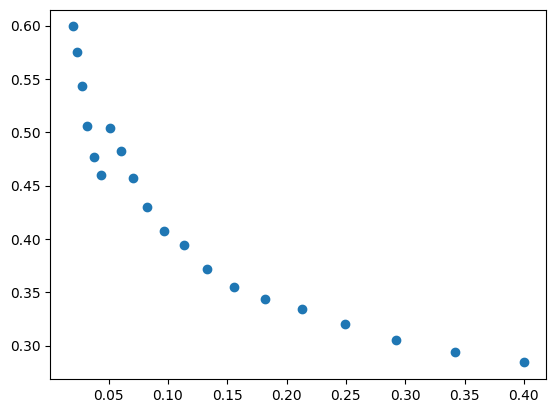

In [54]:
m_effs = np.asarray(m_effs)

plt.scatter(m_effs_OGTPC3[:,0],m_effs_OGTPC3[:,1])

ValueError: weights should have the same shape as x

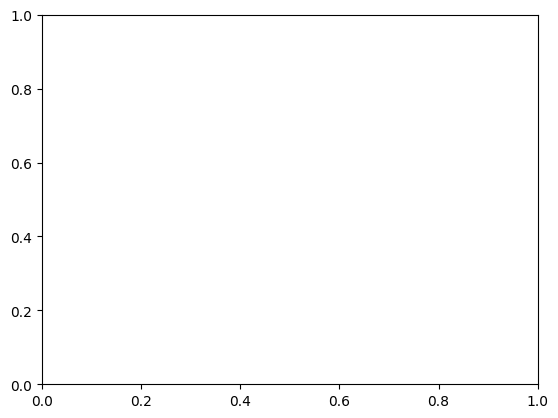

In [20]:
plt.hist(angs, bins=100, range=(0.9,1),edgecolor='black',weights = )
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [8]:
# Extract the relevant sub-arrays
mtms = data.secondary_momenta[:, 1][:, 1:3]

# Extract the vectors for computation
vec1 = mtms[:, 0, 1:4]
vec2 = mtms[:, 1, 1:4]

# Compute the dot product and norms in a vectorized manner
dot_products = np.einsum('ij,ij->i', vec1, vec2)  # Efficient dot product for rows
norms1 = np.linalg.norm(vec1, axis=1)
norms2 = np.linalg.norm(vec2, axis=1)

# Compute cosine of the angle
angles = dot_products / (norms1 * norms2)

plt.hist(angles, bins=100, range=(0.9,1),edgecolor='black',weights = data.event_weight)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()


IndexError: cannot slice ListArray (of length 100000) with array(1): index out of range while attempting to get index 1 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-35/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_next_at.cpp#L21)

In [71]:
weights = data.event_weight
np.sum(data.event_weight*(angles>np.cos(0.9/180*np.pi)))/np.sum(weights)

nan

In [76]:
weights = data.event_weight
np.sum(weights[~np.isnan(weights)])

1.606233855997201e-24

In [10]:
import numpy as np
import os
import siren
import multiprocessing
from siren.SIREN_Controller import SIREN_Controller

def HNL_siren(m4, tr4):

    output_destination='./output_2'
    output_file = f"{output_destination}/TPC2_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example"
    output_file1 = output_file+".parquet"
    output_file2 = output_file+".parquet.parquet"
    
    if os.path.isfile(output_file1) or os.path.isfile(output_file2):
        print(f'{output_file1} has already been done.')
        return 
    
    try:
        # Define a DarkNews model
        model_kwargs = {
            "m4": m4,  # 0.140,
            "mu_tr_mu4": tr4,  # 1e-6, # GeV^-1
            "UD4": 0,
            "Umu4": 0,
            "epsilon": 0.0,
            "gD": 0.0,
            "decay_product": "e+e-",
            "noHC": True,
            "HNLtype": "dirac",
        }

        # Number of events to inject
        events_to_inject = 1000

        # Expeirment to run
        experiment = "TPC2"

        # Define the controller
        controller = SIREN_Controller(events_to_inject, experiment)

        # Particle to inject
        primary_type = siren.dataclasses.Particle.ParticleType.NuMu

        xs_path = siren.utilities.get_cross_section_model_path(f"DarkNewsTables-v{siren.utilities.darknews_version()}", must_exist=False)
        # Define DarkNews Model
        table_dir = os.path.join(
            xs_path,
            "Dipole_M%2.2e_mu%2.2e" % (model_kwargs["m4"], model_kwargs["mu_tr_mu4"]),
        )
        controller.InputDarkNewsModel(primary_type, table_dir, use_pickles=False, **model_kwargs)

        # Primary distributions
        primary_injection_distributions = {}
        primary_physical_distributions = {}

        # energy distribution
        flux_file = siren.utilities.get_tabulated_flux_file("T2K_NEAR","PLUS_numu")
        edist = siren.distributions.TabulatedFluxDistribution(flux_file, True)
        edist_gen = siren.distributions.TabulatedFluxDistribution(
            model_kwargs["m4"], 20, flux_file, False
        )
        primary_injection_distributions["energy"] = edist_gen
        primary_physical_distributions["energy"] = edist

        # direction distribution
        direction_distribution = siren.distributions.FixedDirection(siren.math.Vector3D(0, 0, 1.0))
        primary_injection_distributions["direction"] = direction_distribution
        primary_physical_distributions["direction"] = direction_distribution

        # position distribution
        decay_range_func = siren.distributions.DecayRangeFunction(
            model_kwargs["m4"], controller.DN_min_decay_width, 3, 284.9
        )
        position_distribution = siren.distributions.RangePositionDistribution(
            2.4, 5.3, decay_range_func, set(controller.GetDetectorModelTargets()[0])
        )
        primary_injection_distributions["position"] = position_distribution

        # SetProcesses
        controller.SetProcesses(
            primary_type, primary_injection_distributions, primary_physical_distributions
        )

        controller.Initialize()

        def stop(datum, i):
            secondary_type = datum.record.signature.secondary_types[i]
            return secondary_type != siren.dataclasses.Particle.ParticleType.N4

        controller.injector.SetStoppingCondition(stop)

        events = controller.GenerateEvents(fill_tables_at_exit=False)
        output_destination='./output_2'
        os.makedirs(output_destination, exist_ok=True)

        controller.SaveEvents(
            output_destination+"/TPC2_Dipole_M%2.2e_mu%2.2e_example"
            % (model_kwargs["m4"], model_kwargs["mu_tr_mu4"]),
            fill_tables_at_exit=True
        )
    except Exception as e:
        print(e)
        return
        

if __name__ == '__main__':
    
    n_m = 10
    n_mu = 10
    m_sample = np.geomspace(1e-2,2,n_m)
    mu_sample = np.geomspace(1e-7,1e-5,n_mu)
    m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
    m_sample = np.reshape(m_sample,[n_m*n_mu])
    mu_sample = np.reshape(mu_sample,[n_m*n_mu])

    HNL_siren(m_sample[9],mu_sample[9])
  

Initializing the three-portal model.
table dir:  /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M2.00e+00_mu1.00e-07
/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M2.00e+00_mu1.00e-07/CrossSection_H1_p-el_nu(mu)_N4_flipping_/

Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M2.00e+00_mu1.00e-07/CrossSection_H1_p-el_nu(mu)_N4_flipping_/' created successfully
/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M2.00e+00_mu1.00e-07/CrossSection_He4_coherent_nu(mu)_N4_flipping_/

Directory '/n/holylfs05/LABS/

Added 5 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 5 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 6 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 6 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 7 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 7 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or the interpolator doesn't yet exist. Filling total table
Added 7 points
Requested interpolation at 2.26 GeV. Either this is above the table boundary or

KeyboardInterrupt: 

In [9]:
os.path.isdir('/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M2.00e+00_mu1.00e-07/')

False

In [6]:
for i, (m, mu) in enumerate(zip(m_sample[0:10],mu_sample[0:10])):
    print(i)
    if not os.path.isfile(f"output_2/TPC4_Dipole_M{m:2.2e}_mu{mu:2.2e}_example.parquet"):
        
        print(f'{i} {m:2.2e} {mu:2.2e}\n')
        
        

0
1
2
3
4
5
6
7
8
9
9 2.00e+00 1.00e-07

